In [31]:
from torchvision.models.feature_extraction import create_feature_extractor

from torchvision.utils import save_image

import torch

from tqdm import tqdm

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression

from utils.dataset_pretrained import Dataset

import numpy as np

import matplotlib.pyplot as plt

import numpy as np

In [2]:
batch_size = 600

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
alexnet.to(device) # send the alexnet to the chosen device ('cpu' or 'cuda')
alexnet.eval() # set the alexnet to evaluation mode, since you are not training it

model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])
feature_extractor.to(device)
feature_extractor.eval()

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [4]:
# loading dataset + creating train test split for verifying performance
dataset = Dataset("gaze-dataset")

train_set, val_set = torch.utils.data.random_split(dataset, [10000, 1382])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 11382


In [5]:
def fit_pca(feature_extractor, dataloader):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=600, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        # Extract features
        ft = feature_extractor(d[0].to(device))
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())

    return pca

In [6]:
pca = fit_pca(feature_extractor, train_loader)

 94%|█████████▍| 16/17 [03:38<00:13, 13.67s/it]


In [7]:
pca.explained_variance_ratio_

array([5.29500875e-01, 7.85962820e-02, 5.26085222e-02, 4.30798708e-02,
       2.55002535e-02, 1.83820115e-02, 1.70045974e-02, 1.29844985e-02,
       1.15788786e-02, 1.05644931e-02, 9.84884862e-03, 7.92283413e-03,
       7.39982155e-03, 7.13404292e-03, 6.64742651e-03, 6.22354968e-03,
       5.78147186e-03, 5.52960555e-03, 5.10015857e-03, 4.71615325e-03,
       4.08859710e-03, 3.77485776e-03, 3.64835544e-03, 3.33381475e-03,
       3.04511434e-03, 2.78721604e-03, 2.60072780e-03, 2.29346788e-03,
       2.26199444e-03, 2.15468257e-03, 2.11619980e-03, 1.97681233e-03,
       1.91878636e-03, 1.83234041e-03, 1.80604211e-03, 1.72362112e-03,
       1.65147081e-03, 1.58308721e-03, 1.51663716e-03, 1.45139003e-03,
       1.41245223e-03, 1.38091771e-03, 1.25738772e-03, 1.22008572e-03,
       1.19096121e-03, 1.15652610e-03, 1.09796599e-03, 1.09698713e-03,
       1.01803006e-03, 1.00010915e-03, 9.74221547e-04, 9.64864362e-04,
       9.42560508e-04, 8.78782618e-04, 8.48874574e-04, 8.38420114e-04,
      

In [8]:
def extract_features(feature_extractor, dataloader, pca):
    lh_fmri = []
    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        # Extract features
        ft = feature_extractor(d[0].to(device))
        lh_fmri += [d[1].cpu().detach().numpy()]
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features += [ft]
    return (np.vstack(features), np.vstack(lh_fmri))

In [9]:
features_train, labels_train = extract_features(feature_extractor, train_loader, pca)
features_val, labels_val = extract_features(feature_extractor, val_loader, pca)

 67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]


In [10]:
model = LinearRegression()

model.fit(features_train, labels_train)

LinearRegression()

In [11]:
output = model.predict(features_val)

differences = np.abs(output - labels_val)

print(np.mean(differences, axis=0))

[0.11132761 0.09823947]


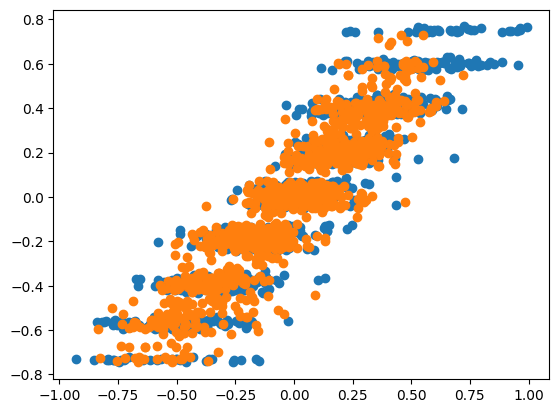

In [12]:
plt.scatter(output[:,0], labels_val[:,0])
plt.scatter(output[:,1], labels_val[:,1])

In [137]:
class RegressionHead(torch.nn.Module):
    def __init__(self):
        super(RegressionHead, self).__init__()
        
        self.linear1 = torch.nn.Linear(600, 2)

    def forward(self, x):
        return self.linear1(x)

In [138]:
regression_head = RegressionHead().to(device)
regression_head.to(device)

RegressionHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=600, out_features=2, bias=True)
)

In [140]:
EPOCHS = 1000

mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)

In [132]:
grad_desc_features = features_train.reshape((-1, 9600, 600))
grad_desc_labels = labels_train.reshape((-1, 9600, 2))

In [133]:
losses = []
val_losses = []

for epoch in range(EPOCHS):
    #print("Epoch: " + str(epoch))

    for i, (inputs, targets) in enumerate(zip(grad_desc_features, grad_desc_labels)):
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)

        output = regression_head(inputs)

        loss = mse_loss(output, torch.tensor(targets, dtype=torch.float32).to(device))
        
        if i == grad_desc_features.shape[0]-1:
            #print("Train loss: " + str(loss.item()))
            losses.append(loss.item())
        
        if loss < 0.5:
            break

        loss.backward()
        
        optimizer.step()

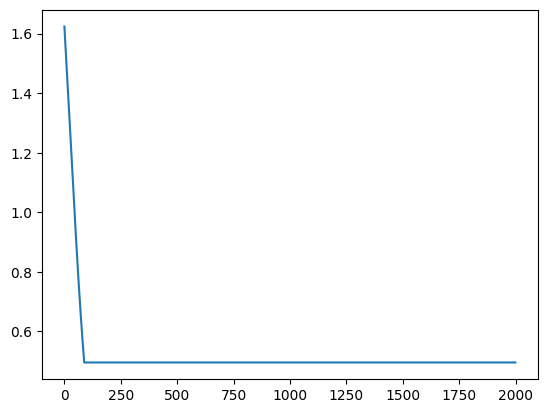

In [134]:
plt.plot(losses)

In [136]:
differences = []
print("pass")
for i, (inputs, targets) in tqdm(enumerate(zip(grad_desc_features, grad_desc_labels))):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)

    output = regression_head(inputs)
    
    if len(differences) == 0:
        differences = np.abs(targets - output.detach().cpu().numpy())
    else:
        differences = np.vstack((differences, np.abs(targets - output.detach().cpu().numpy())))

    print(np.mean(differences, axis=0))

pass


1it [00:00, 188.36it/s]

[0.5512214 0.5508127]
